## IBM Multivariate Time-Series of IoT data

Anomaly detection is to predict either '1' or '-1' values along the anomaly score,  with IoT-sensor data in multivariate time-series.

- Label '1' signifies that these samples at that time points are normals. 
- Label '-1' means these samples are outliers or anomalous. 

Anomaly models are used to generate alarm in real time.


## Init

In [1]:
# Credentials required for running notebook

Client_ID = "replace-with-valid-client-ID"
Client_Secret = "replace-with-valid-client-Secret"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

datafile_name = 'sample2.csv'
data_df = pd.read_csv(datafile_name)

data_df.head(10)

,Time,Value_0,Value_1,Value_2,Value_3
0,0,3.000000,0.000000,-3.000000,-2.000000
1,1,1.572558,0.270133,-3.320124,-1.583921
2,2,1.873181,0.048440,-3.154067,-1.974031
3,3,1.361140,-0.211421,-3.292858,-2.414144
4,4,1.408475,-0.559694,-3.080145,-2.242305
5,5,1.908858,-0.536122,-3.238631,-1.898070
6,6,0.471416,-0.513129,-3.185812,-1.493719
7,7,-0.755087,-0.605181,-3.362431,-1.373513
8,8,-1.636673,-0.282153,-3.708064,-1.740503
9,9,-0.663525,0.045805,-3.427077,-1.383114


## Plot to show the sensor data for each of the variables.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

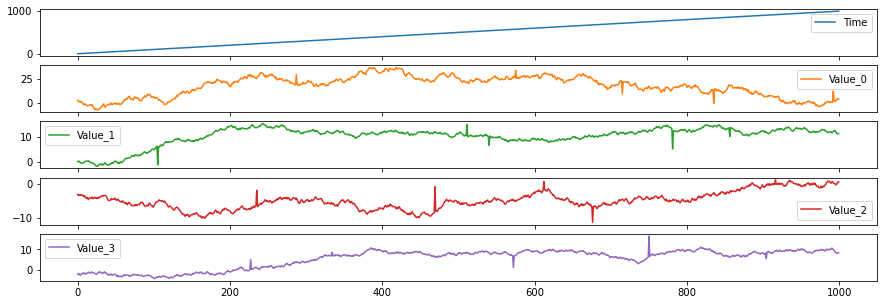

In [3]:
data_df.plot(subplots=True, figsize=(15, 5))

## Prep data for service creation and job Submission 

In [4]:
import numpy as np

time_column = "Time"
feature_columns = np.setdiff1d(data_df.columns, time_column)
target_columns = np.setdiff1d(data_df.columns, time_column)
time_format="%Y-%m-%d %H:%M:%S"

In [5]:
file_path = datafile_name
files = {'data_file': (datafile_name, open(file_path, 'rb'))}
data = {
    'target_columns': str(list(target_columns)),
    'time_column': time_column,
    'time_format': time_format,
    'prediction_type': 'entire',
    'algorithm_type': 'DeepAD',
    'lookback_window': 'auto',
    'observation_window': 10,
    'labeling_method': 'Chi-Square',
    'labeling_threshold': 10,
    'anomaly_estimator': 'Default',
}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

import requests
post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/multivariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  63db01f7-6350-4954-99bd-9c7fa9a91927


## Get Job <a id="pipelineCreation"></a>

it takes a while to go from "queued" -> "executed" -> "done", so you may need to run this cell several times.

In [11]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 63db01f7-6350-4954-99bd-9c7fa9a91927 is done.


In [12]:
print(json_data)

{'filename': 'sample2.csv', 'jobId': '63db01f7-6350-4954-99bd-9c7fa9a91927', 'prediction_type': 'entire', 'status': 'done', 'summary': {'lookback_window': '29', 'model_summary': "[('SkipTransformer',NoOp()),('NormalizedFlatten',NormalizedFlatten(feature_columns=[1,2,3,4],lookback_win=29,target_columns=[1,2,3,4])),('RandomForestRegressor',MultiOutputRegressor(estimator=RandomForestRegressor(random_state=0))),]", 'num_pipelines_explored': 75, 'num_pipelines_finished': 75, 'result': [{'timestamp': '1970-01-01 00:00:00.000000000', 'value': {'anomaly_label': [1.0], 'anomaly_score': [nan]}}, {'timestamp': '1970-01-01 00:00:00.000000001', 'value': {'anomaly_label': [1.0], 'anomaly_score': [nan]}}, {'timestamp': '1970-01-01 00:00:00.000000002', 'value': {'anomaly_label': [1.0], 'anomaly_score': [nan]}}, {'timestamp': '1970-01-01 00:00:00.000000003', 'value': {'anomaly_label': [1.0], 'anomaly_score': [nan]}}, {'timestamp': '1970-01-01 00:00:00.000000004', 'value': {'anomaly_label': [1.0], 'anom

## Result and plotting <a id="groundtruth"></a>

In [13]:
result = []
result_header = ['timestamp', 'anomaly_score', 'anomaly_label']

for item in json_data['summary']['result']:
    result.append([item['timestamp'], item['value']['anomaly_score'][0], item['value']['anomaly_label'][0]])

result = pd.DataFrame(result)
result.columns = result_header
result.tail(10)

,timestamp,anomaly_score,anomaly_label
990,1970-01-01 00:00:00.000000990,0.341999,1.0
991,1970-01-01 00:00:00.000000991,0.059326,1.0
992,1970-01-01 00:00:00.000000992,1.429587,1.0
993,1970-01-01 00:00:00.000000993,0.174729,1.0
994,1970-01-01 00:00:00.000000994,0.074200,1.0
995,1970-01-01 00:00:00.000000995,2.642214,1.0
996,1970-01-01 00:00:00.000000996,-0.008201,1.0
997,1970-01-01 00:00:00.000000997,0.293882,1.0
998,1970-01-01 00:00:00.000000998,0.104345,1.0
999,1970-01-01 00:00:00.000000999,0.004547,1.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

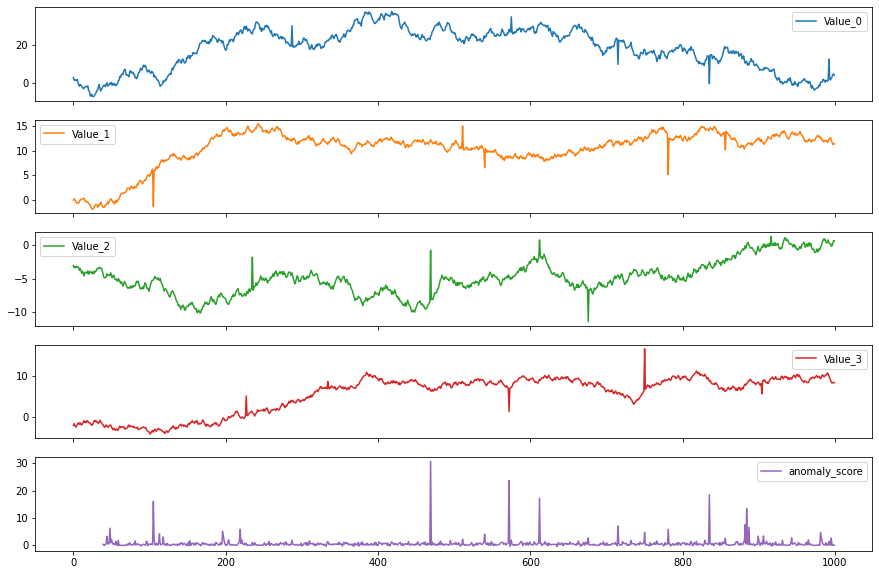

In [14]:
plot_data_df = data_df.copy()
plot_data_df['anomaly_score'] = result['anomaly_score']
cols = list(target_columns)
cols.append('anomaly_score')
plot_data_df[cols].plot(subplots=True, figsize=(15, 10))